In [1]:
import os 
import pytorch_lightning as pl
import seml
import numpy as np
import torch
from sacred import SETTINGS, Experiment
from functools import partial

import scanpy as sc

from scCFM.models.cfm.cfm_module import CFMLitModule

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from torch.optim import AdamW

import yaml

import sys 
sys.path.insert(0, "../../../" )
from paths import EXPERIMENT_FOLDER

**Import configs**

In [2]:
with open("/nfs/homedirs/pala/scCFM/configs/eb/config.yaml", "r") as stream:
    hparams = yaml.safe_load(stream)["fixed"]

In [ ]:
task_name = hparams["training.training"]["task_name"]
        
# Fix seed for reproducibility
torch.manual_seed(hparams["training.training"]["seed"])      
if hparams["training.training"]["seed"]: 
    pl.seed_everything(hparams["training.training"]["seed"], workers=True)

# Initialize folder 
current_experiment_dir = EXPERIMENT_FOLDER / task_name
current_experiment_dir.mkdir(parents=True, exist_ok=True) 
    

# Initialize datamodule
datamodule = TrajectoryDataModule(**hparams["datamodule.datamodule"])
    

# Neural network 
net = partial(VelocityNet, **hparams["net.net"])   


# Initialize the model 
model = CFMLitModule(
                    net=net,
                    datamodule=datamodule,
                    **hparams["model.model"]
                    ) 
        

# Initialize callbacks 
model_ckpt_callbacks = ModelCheckpoint(dirpath=current_experiment_dir / "checkpoints", 
                                        **hparams["model_checkpoint.model_checkpoint"])


# Initialize callbacks 
early_stopping_callbacks = EarlyStopping(**hparams["early_stopping.early_stopping"])
        

# Initialize logger 
logger = WandbLogger(save_dir=current_experiment_dir / "logs", 
                     **hparams["logger.logger"]) 
        

# Initialize the lightning trainer 
trainer = Trainer(default_root_dir=current_experiment_dir,
                  callbacks=[model_ckpt_callbacks, early_stopping_callbacks], 
                  logger=logger, 
                  **hparams["trainer.trainer"])
        

# Fit the model 
trainer.fit(model=model, 
                  train_dataloaders=datamodule.train_dataloader(load_full=True),
                  val_dataloaders=datamodule.val_dataloader(load_full=False))
train_metrics = trainer.callback_metrics

# # Test model 
# ckpt_path = trainer.checkpoint_callback.best_model_path
# if ckpt_path == "":
#     ckpt_path = None
# trainer.test(model=model, datamodule=datamodule, ckpt_path=ckpt_path)
# test_metrics = trainer.callback_metrics

# # merge train and test metrics
# metric_dict = {**train_metrics, **test_metrics}

[rank: 0] Global seed set to 42
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: allepalma. Use `wandb login --relogin` to force relogin
wandb: WARNING Path /nfs/homedirs/pala/scCFM/project_dir/experiments/eb/logs/wandb/ wasn't writable, using system temp directory.
wandb: WARNING Path /nfs/homedirs/pala/scCFM/project_dir/experiments/eb/logs/wandb/ wasn't writable, using system temp directory


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-pa ...
  rank_zero_warn(
/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/pytorch_lightning

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

**Analysis velocity**

In [ ]:
adata = sc.read_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/eb_phate.h5ad")
adata

In [ ]:
def add_velocity_to_adata(adata, model):
    # Put model in evaluation mode
    model.eval()
    velocities = []
    with torch.no_grad():
        for i, x in enumerate(adata.X.A):
            t = torch.tensor(adata.obs.experimental_time[i]).view(1, -1).float()
            x = torch.from_numpy(x).to(model.device).view(1, -1).float()
            dx_dt = model(t,x)
            velocities.append(dx_dt.cpu().numpy())
    velocities = np.concatenate(velocities, axis=0)

    adata.layers["velocity"] = velocities

In [ ]:
add_velocity_to_adata(adata, model)

In [ ]:
vk = cr.kernels.VelocityKernel(adata,
                          xkey="X_log", 
                        vkey="velocity").compute_transition_matrix()

vk.compute_projection(basis="umap")


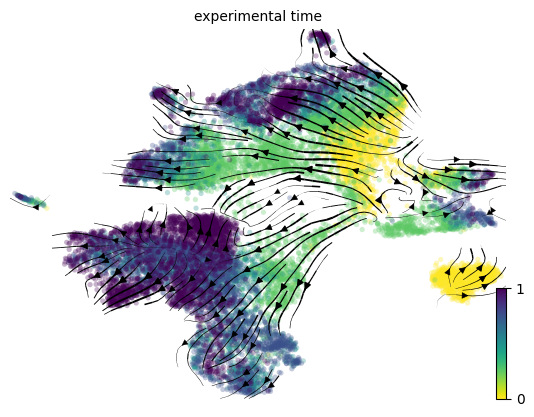

In [9]:
scv.pl.velocity_embedding_stream(adata, vkey="T_fwd", basis="umap", color="experimental_time")